In [1]:
library(tidyverse)
library(repr)
library(tidymodels)
library(RColorBrewer)
options(repr.matrix.max.rows = 6)

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.1 ──

✔ ggplot2 3.3.6     ✔ purrr   0.3.4
✔ tibble  3.1.7     ✔ dplyr   1.0.9
✔ tidyr   1.2.0     ✔ stringr 1.4.0
✔ readr   2.1.2     ✔ forcats 0.5.1

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

── Attaching packages ────────────────────────────────────── tidymodels 1.0.0 ──

✔ broom        1.0.0     ✔ rsample      1.0.0
✔ dials        1.0.0     ✔ tune         1.0.0
✔ infer        1.0.2     ✔ workflows    1.0.0
✔ modeldata    1.0.0     ✔ workflowsets 1.0.0
✔ parsnip      1.0.0     ✔ yardstick    1.0.0
✔ recipes      1.0.1     

── Conflicts ───────────────────────────────────────── tidymodels_conflicts() ──
✖ scales::discard() masks purrr::discard()
✖ dplyr::filter()   masks stats::filter()
✖ recipes::fixed()  masks stringr::fixed()
✖ dplyr::lag()      masks stats::lag()
✖ yardstick::spec() masks r

#### Table 1: Tidy Processed Cleveland Dataset

In [2]:
cleveland_data <- read_csv("https://archive.ics.uci.edu/ml/machine-learning-databases/heart-disease/processed.cleveland.data",
        col_names = FALSE)

colnames(cleveland_data) <- c("age", "sex", "cp", "trestbps", "chol", "fbs", "restecg", "thalach", "exang", "oldpeak", "slope", "ca", "thal", "num")

tidy_cleveland_data <- cleveland_data |>
select("age", "trestbps", "chol", "thalach", "oldpeak", "thal") |>
mutate(across(age:thal, ~na_if(., "?"))) #This line of code was referenced from Wickham et al. (n.d.)
tidy_cleveland_data$thal[tidy_cleveland_data$thal == "3.0"] <- "normal" #This line of code was referenced from Naveen (2022)
tidy_cleveland_data$thal[tidy_cleveland_data$thal == "6.0"] <- "fixed_defect" #This line of code was referenced from Naveen (2022)
tidy_cleveland_data$thal[tidy_cleveland_data$thal == "7.0"] <- "reversible_defect" #This line of code was referenced from Naveen (2022)
tidy_cleveland_data <- mutate(tidy_cleveland_data, thal = as.factor(thal))
tidy_cleveland_data

Rows: 303 Columns: 14
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr  (2): X12, X13
dbl (12): X1, X2, X3, X4, X5, X6, X7, X8, X9, X10, X11, X14

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


age,trestbps,chol,thalach,oldpeak,thal
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>
63,145,233,150,2.3,fixed_defect
67,160,286,108,1.5,normal
67,120,229,129,2.6,reversible_defect
⋮,⋮,⋮,⋮,⋮,⋮
57,130,131,115,1.2,reversible_defect
57,130,236,174,0.0,normal
38,138,175,173,0.0,normal


#### Table 2: Training Cleveland Dataset

In [3]:
set.seed(234) 
cleveland_split <- initial_split(tidy_cleveland_data, prop = 0.75, strata = thal)  
cleveland_train <- training(cleveland_split)   
cleveland_train

age,trestbps,chol,thalach,oldpeak,thal
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>
63,145,233,150,2.3,fixed_defect
37,130,250,187,3.5,normal
41,130,204,172,1.4,normal
⋮,⋮,⋮,⋮,⋮,⋮
63,140,187,144,4.0,reversible_defect
68,144,193,141,3.4,reversible_defect
57,130,131,115,1.2,reversible_defect


#### Table 3: Testing Cleveland Dataset

In [4]:
set.seed(234) 
cleveland_test <- testing(cleveland_split)
cleveland_test

age,trestbps,chol,thalach,oldpeak,thal
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>
67,160,286,108,1.5,normal
67,120,229,129,2.6,reversible_defect
62,140,268,160,3.6,normal
⋮,⋮,⋮,⋮,⋮,⋮
57,140,241,123,0.2,reversible_defect
45,110,264,132,1.2,reversible_defect
57,130,236,174,0.0,normal


#### Table 4: Means of the Predictor Variables 

In [5]:
cleveland_table <- cleveland_train |>
summarize(across(age:oldpeak, mean))
cleveland_table

age,trestbps,chol,thalach,oldpeak
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
53.95595,131.5903,244.2952,150.5507,1.040088


#### Table 5: Number of Observations in Each Class

In [6]:
cleveland_table_2 <- group_by(cleveland_train, thal) |>
summarize(count = n())
cleveland_table_2

thal,count
<fct>,<int>
fixed_defect,12
normal,126
reversible_defect,88
NA,1


#### Table 6: Rows That Have Missing Data

In [7]:
cleveland_table_3 <- cleveland_train[!complete.cases(cleveland_train), ] #This line of code was referenced from Gili (2022)
cleveland_table_3

age,trestbps,chol,thalach,oldpeak,thal
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>
53,128,216,115,0,NA


#### Table 7: Number of Rows That Have Missing Data per Column

In [9]:
cleveland_table_4 <- cleveland_train |>
    map_df(~ sum(is.na(.))) #This line of code was referenced from Kiniry (2019).
cleveland_table_4

age,trestbps,chol,thalach,oldpeak,thal
<int>,<int>,<int>,<int>,<int>,<int>
0,0,0,0,0,1


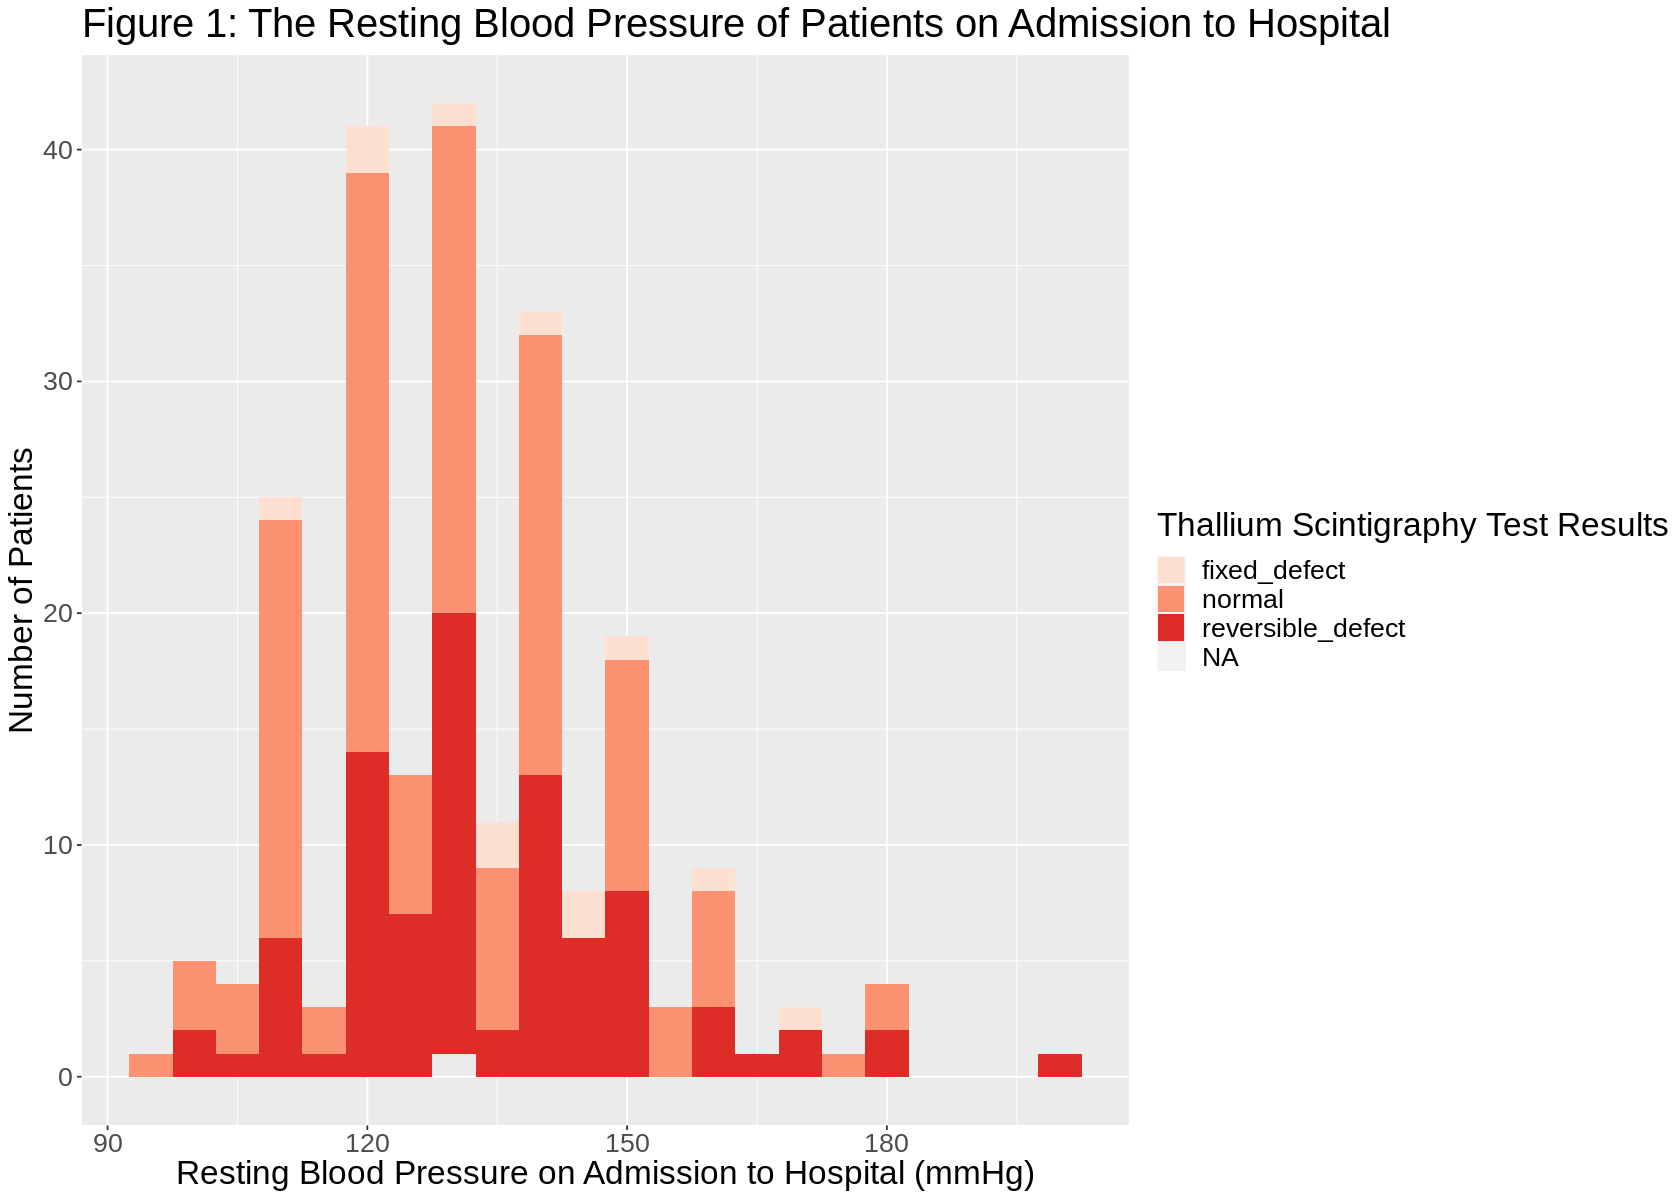

In [10]:
options(repr.plot.width = 14, repr.plot.height = 10)
cleveland_plot_1 <- cleveland_train |>
    ggplot(aes(x = trestbps, fill = thal)) +
    geom_histogram(binwidth = 5) +
    labs(x = "Resting Blood Pressure on Admission to Hospital (mmHg)", y = "Number of Patients",  fill = "Thallium Scintigraphy Test Results") +
    ggtitle("Figure 1: The Resting Blood Pressure of Patients on Admission to Hospital") +
    scale_fill_brewer(palette = "Reds")+
    theme(text = element_text(size = 20))
cleveland_plot_1

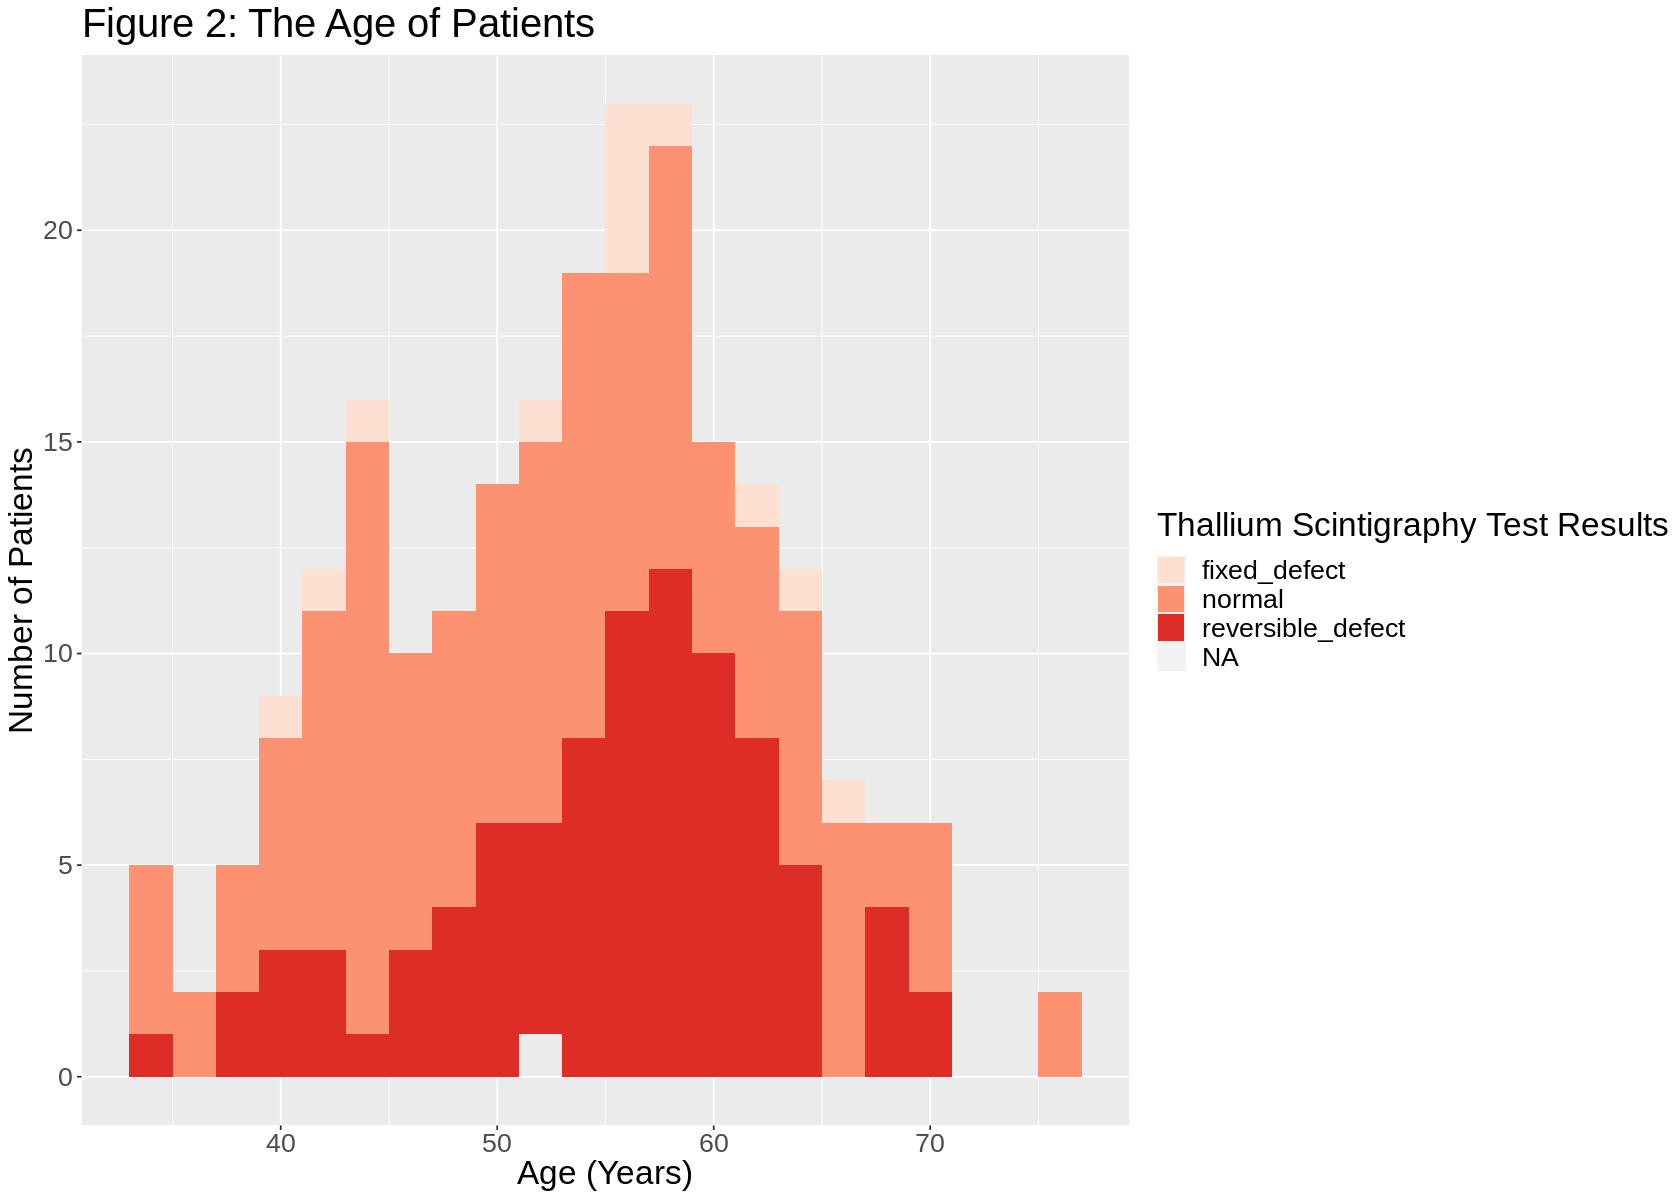

In [11]:
cleveland_plot_2 <- cleveland_train |>
    ggplot(aes(x = age, fill = thal)) +
    geom_histogram(binwidth = 2) +
    labs(x = "Age (Years)", y = "Number of Patients",  fill = "Thallium Scintigraphy Test Results") +
    ggtitle("Figure 2: The Age of Patients") +
    scale_fill_brewer(palette = "Reds") +
    theme(text = element_text(size = 20))
cleveland_plot_2

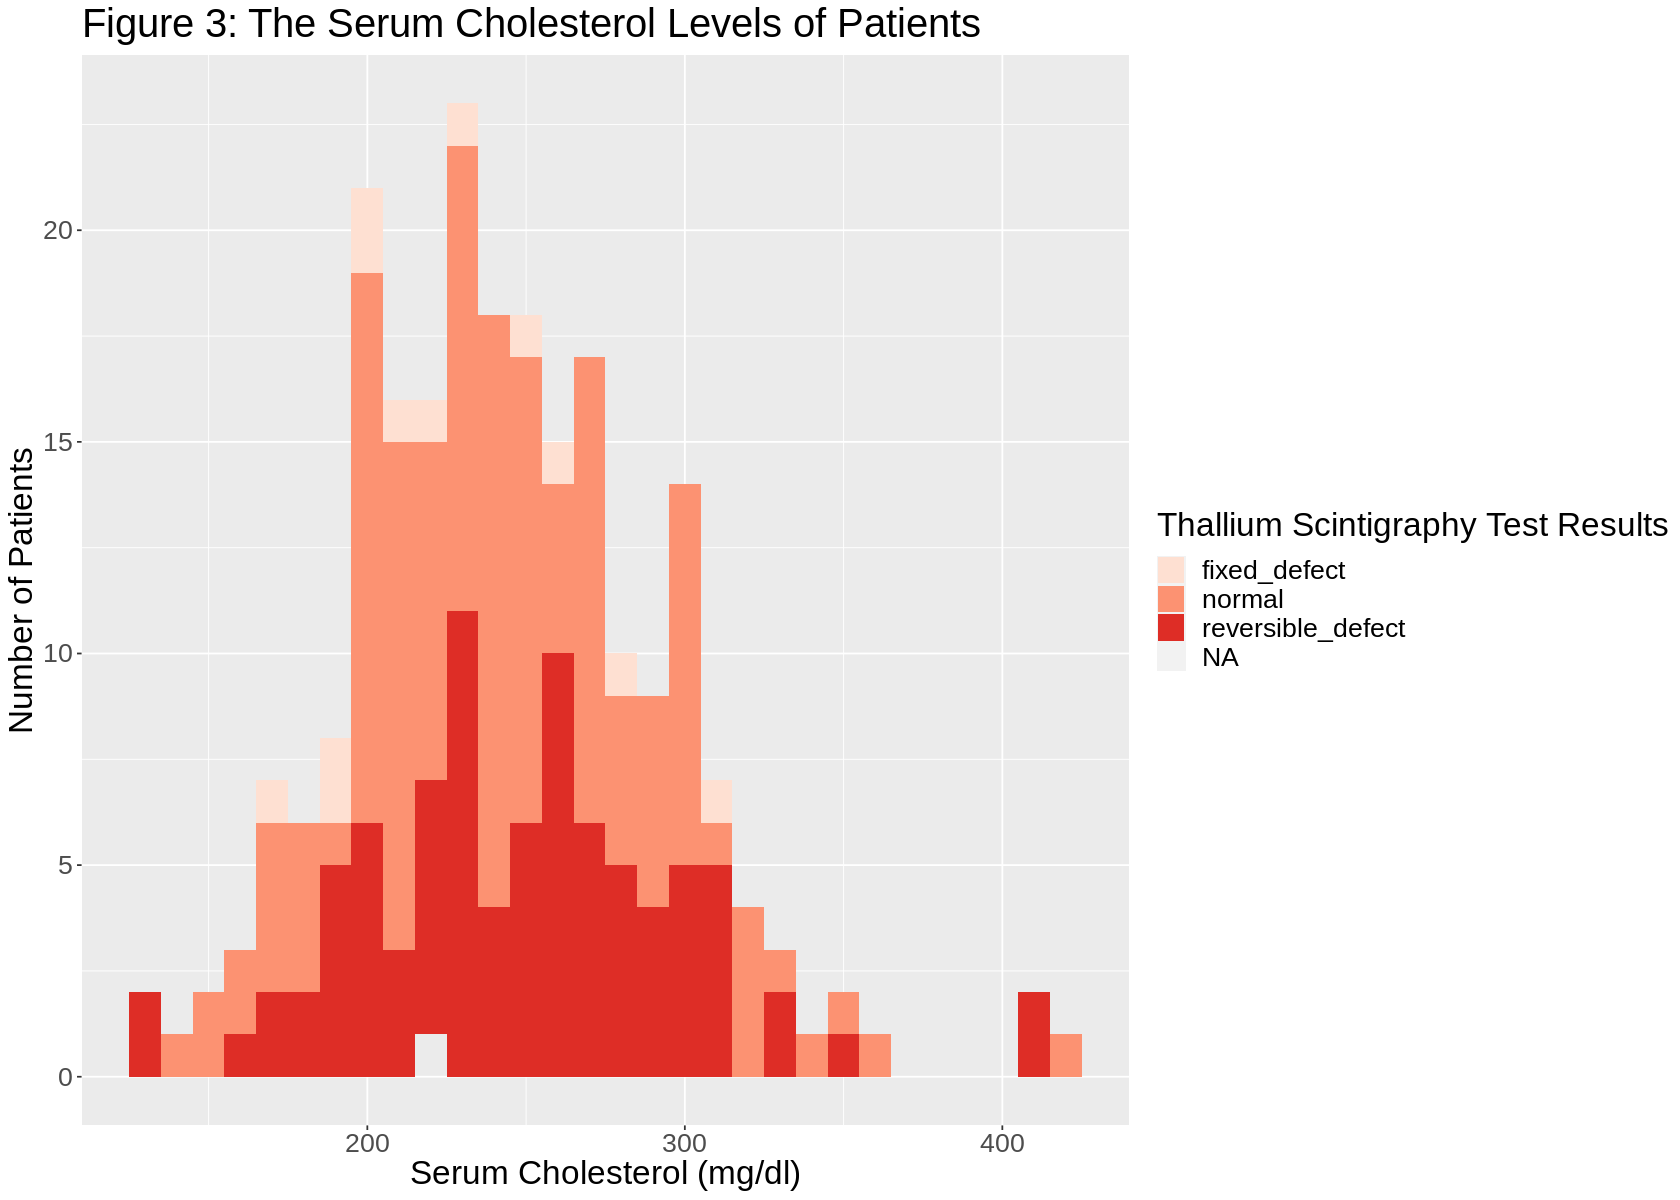

In [12]:
cleveland_plot_3 <- cleveland_train |>
    ggplot(aes(x = chol, fill = thal)) +
    geom_histogram(binwidth = 10) +
    labs(x = "Serum Cholesterol (mg/dl)", y = "Number of Patients",  fill = "Thallium Scintigraphy Test Results") +
    ggtitle("Figure 3: The Serum Cholesterol Levels of Patients") +
    scale_fill_brewer(palette = "Reds") +
    theme(text = element_text(size = 20))
cleveland_plot_3

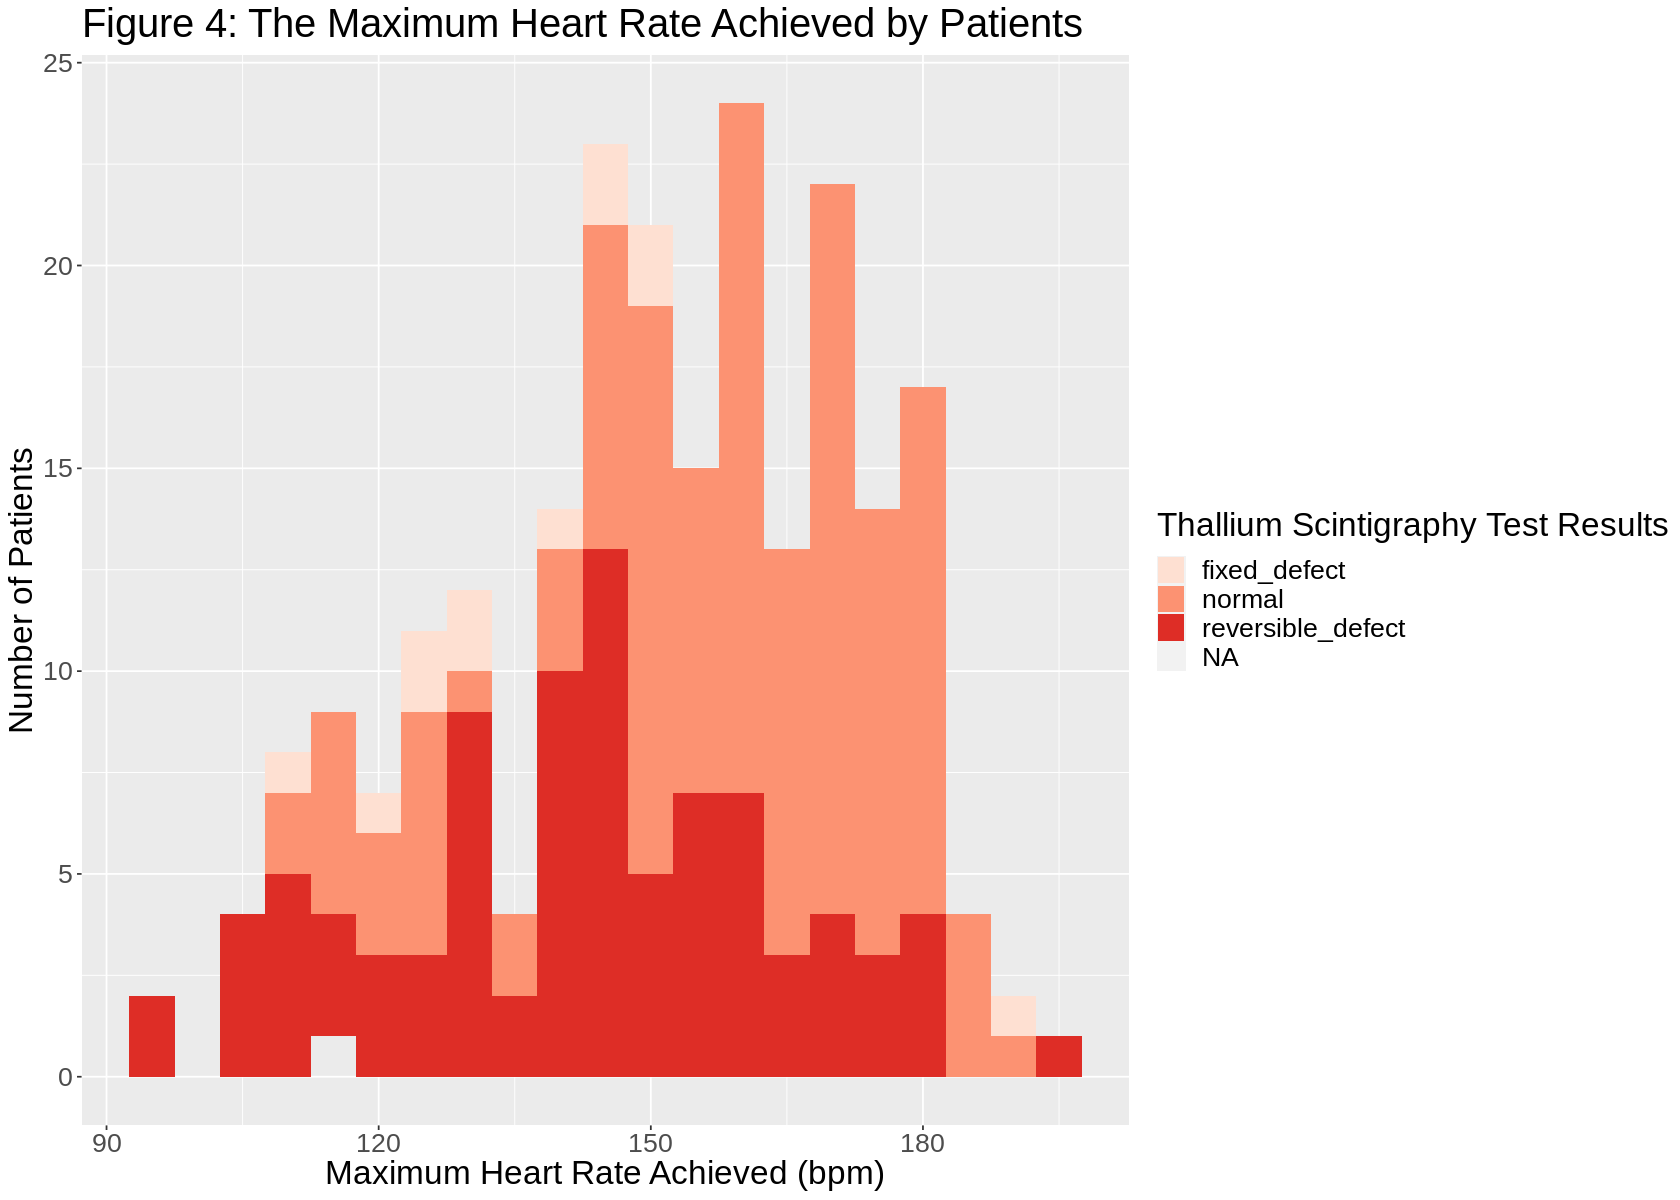

In [13]:
cleveland_plot_4 <- cleveland_train |>
    ggplot(aes(x = thalach, fill = thal)) +
    geom_histogram(binwidth = 5) +
    labs(x = "Maximum Heart Rate Achieved (bpm)", y = "Number of Patients",  fill = "Thallium Scintigraphy Test Results") +
    ggtitle("Figure 4: The Maximum Heart Rate Achieved by Patients") +
    scale_fill_brewer(palette = "Reds") +
    theme(text = element_text(size = 20))
cleveland_plot_4

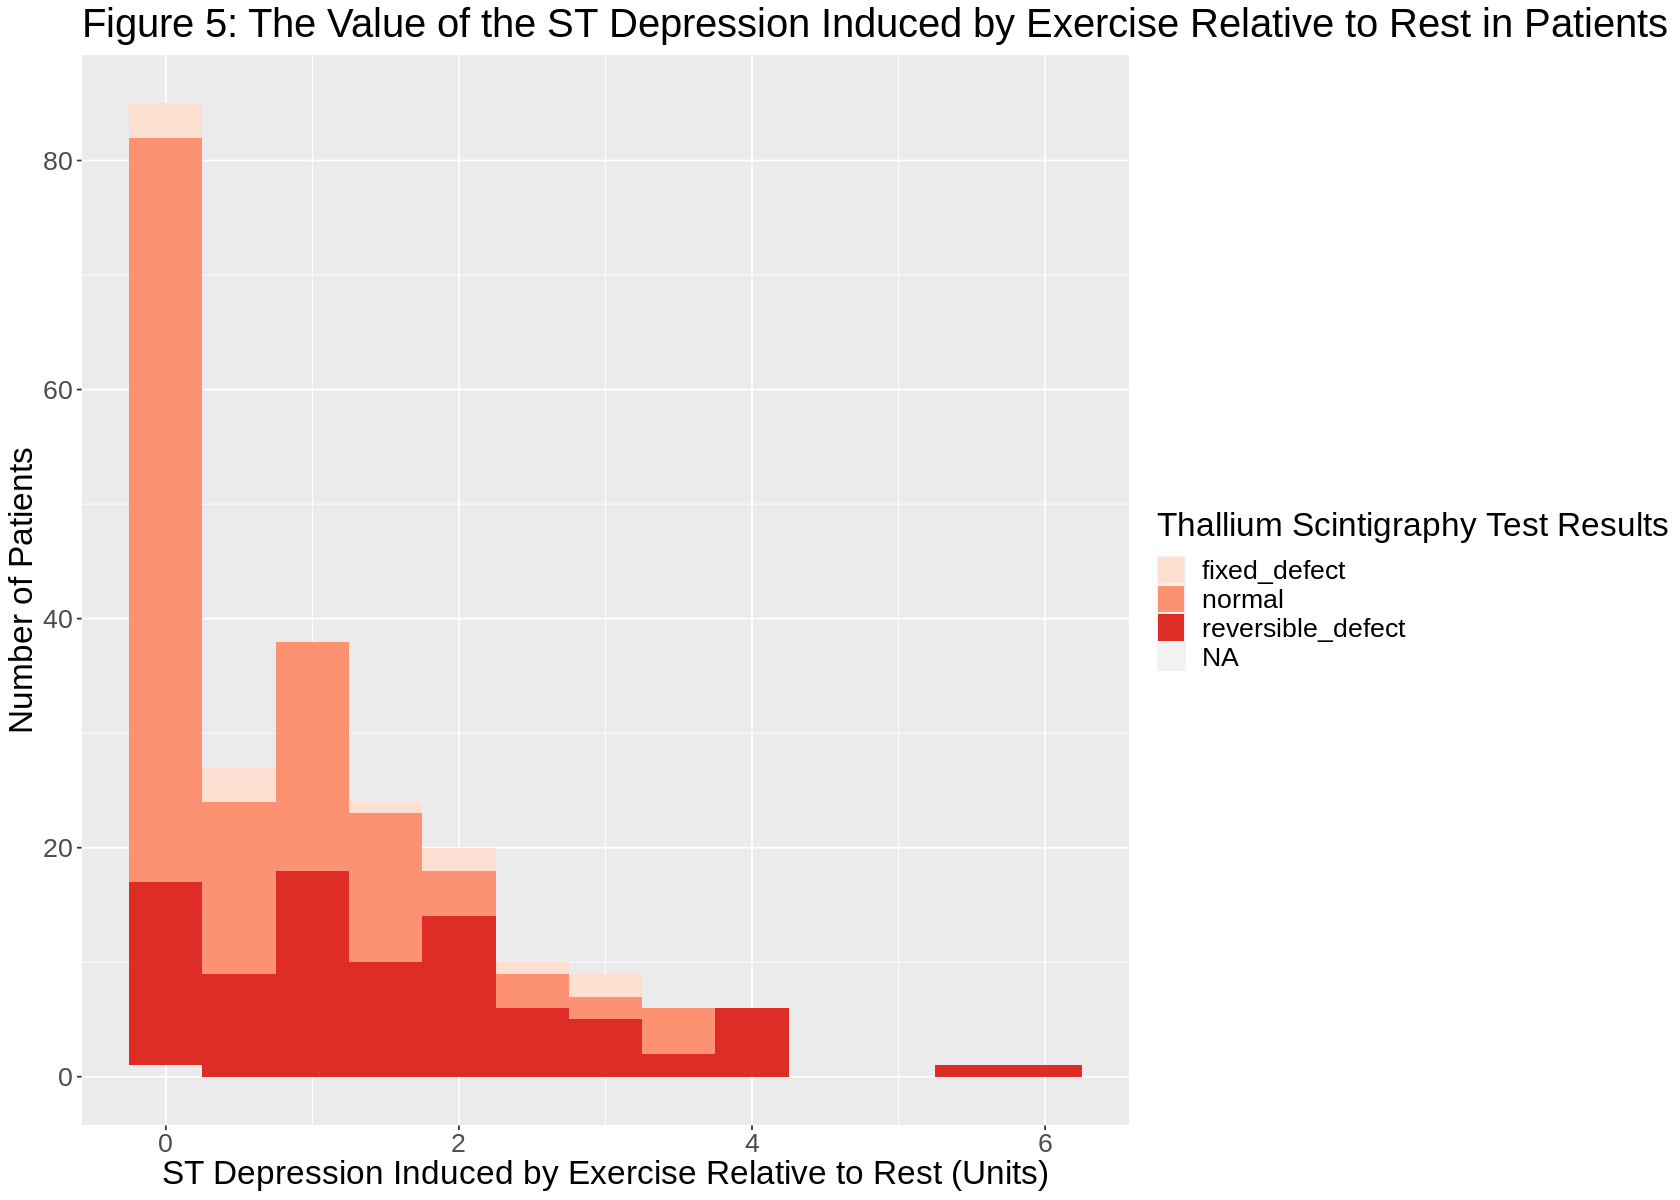

In [14]:
cleveland_plot_5 <- cleveland_train |>
    ggplot(aes(x = oldpeak, fill = thal)) +
    geom_histogram(binwidth = 0.5) +
    labs(x = "ST Depression Induced by Exercise Relative to Rest (Units)", y = "Number of Patients",  fill = "Thallium Scintigraphy Test Results") +
    ggtitle("Figure 5: The Value of the ST Depression Induced by Exercise Relative to Rest in Patients") +
    scale_fill_brewer(palette = "Reds") +
    theme(text = element_text(size = 20))
cleveland_plot_5

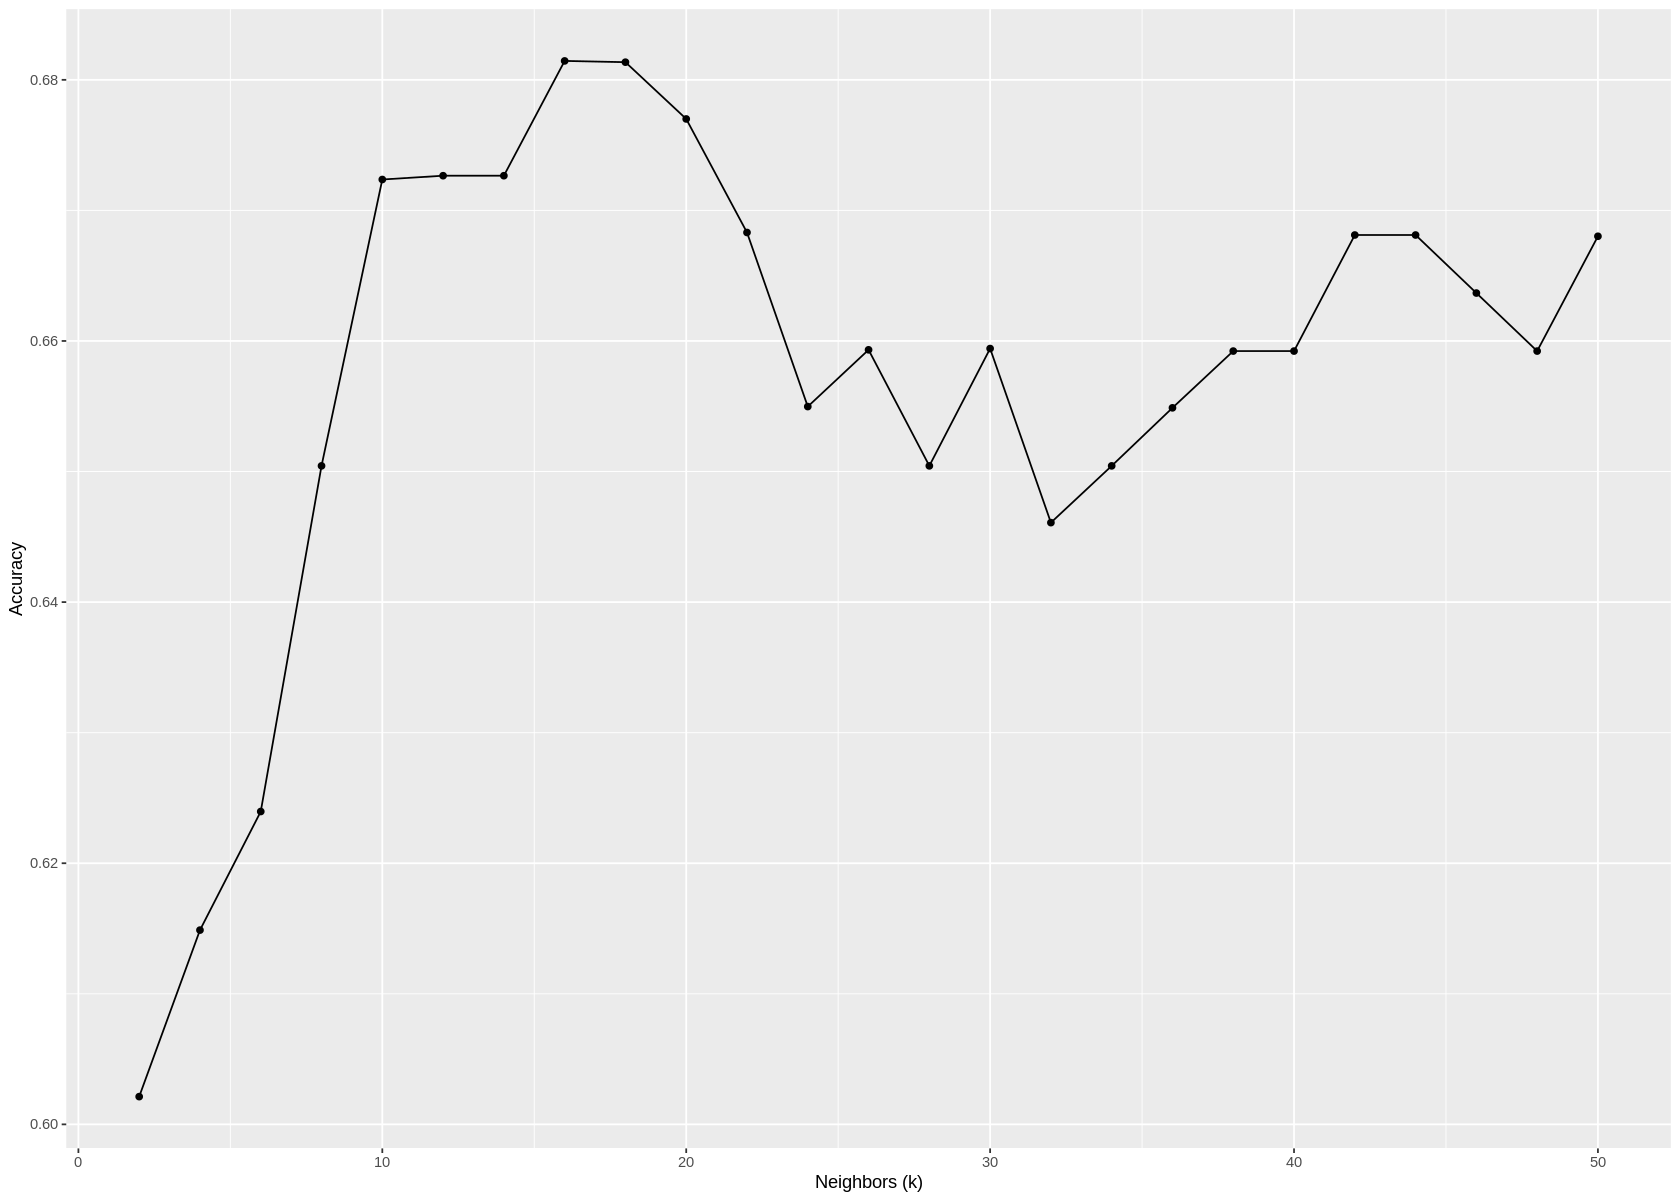

In [66]:
set.seed(7777)

cleveland_recipe <- recipe(thal ~ ., data = cleveland_train)

knn_tune <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) |>
       set_engine("kknn") |>
       set_mode("classification")

cleveland_vfold <- vfold_cv(cleveland_train, v = 5, strata = thal)

k_value <- tibble(neighbors = seq(from = 2, to = 50, by = 2))

cleveland_results <- workflow() |>
       add_recipe(cleveland_recipe) |>
       add_model(knn_tune) |>
       tune_grid(resamples = cleveland_vfold, grid = k_value) |>
       collect_metrics()

cross_val_plot <- cleveland_results |>
filter(.metric == "accuracy") |>
ggplot(aes(x = neighbors, y = mean)) +
  geom_point() +
  geom_line() +
  labs(x = "Neighbors (k)", y = "Accuracy")
cross_val_plot


In [71]:
cleveland_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = 14) |>
       set_engine("kknn") |>
       set_mode("classification")

cleveland_fit <- workflow() |>
       add_recipe(cleveland_recipe) |>
       add_model(cleveland_spec) |>
       fit(data = cleveland_train)
cleveland_fit

══ Workflow [trained] ══════════════════════════════════════════════════════════
Preprocessor: Recipe
Model: nearest_neighbor()

── Preprocessor ────────────────────────────────────────────────────────────────
0 Recipe Steps

── Model ───────────────────────────────────────────────────────────────────────

Call:
kknn::train.kknn(formula = ..y ~ ., data = data, ks = min_rows(14,     data, 5), kernel = ~"rectangular")

Type of response variable: nominal
Minimal misclassification: 0.3362832
Best kernel: rectangular
Best k: 14

In [72]:
cleveland_predictions <- predict(cleveland_fit, cleveland_test) |>
       bind_cols(cleveland_test)
cleveland_predictions

cleveland_metrics <- cleveland_predictions |>
metrics(truth = thal, estimate = .pred_class) 
cleveland_metrics

cleveland_conf_mat <- cleveland_predictions |>
       conf_mat(truth = thal, estimate = .pred_class)
cleveland_conf_mat

.pred_class,age,trestbps,chol,thalach,oldpeak,thal
<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>
reversible_defect,67,160,286,108,1.5,normal
reversible_defect,67,120,229,129,2.6,reversible_defect
reversible_defect,62,140,268,160,3.6,normal
⋮,⋮,⋮,⋮,⋮,⋮,⋮
reversible_defect,57,140,241,123,0.2,reversible_defect
normal,45,110,264,132,1.2,reversible_defect
normal,57,130,236,174,0.0,normal


.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
accuracy,multiclass,0.5600000
kap,multiclass,0.1561541


                   Truth
Prediction          fixed_defect normal reversible_defect
  fixed_defect                 0      0                 0
  normal                       0     30                17
  reversible_defect            6     10                12